### Dataset parsing

I downloaded the dataset in bibtex format, so I needed a bibtex parser to extract the relevant information and start working on it. I here use the BibTexParser python library, with some additional customization.

In [1]:
#*******************************
# Importing packages
#*******************************
import os
import sys
import ast
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import bibtexparser
from bibtexparser.bparser import BibTexParser
from bibtexparser.customization import *
from collections import Counter
#*******************************
%matplotlib inline

In [2]:
def customizations(record):
    """
    Input record: a record
    Output: customized record
    """
    record = type(record)
    record = author(record)
    record = editor(record)
    record = journal(record)
    record = keyword(record)
    record = link(record)
    record = page_double_hyphen(record)
    record = doi(record)
    return record
#end

In [3]:
def get_retraction_list():
    n_files = 9
    base_filename = 'retraction_records_' #the name I gave to my downloaded files
    retraction_ls = list()

    parser = BibTexParser()
    parser.customization = customizations

    for ifile in range(1, n_files+1):
        filename = base_filename + str(ifile).zfill(2) + '.bib'
        with open(filename) as rec_file:
            recs_str = rec_file.read()
        #end
        retraction_ls.extend(bibtexparser.loads(recs_str, parser=parser).entries)
    #end         
    return retraction_ls
#end

def build_retraction_dc(retraction_ls):
    full_key_ls = list()
    for rec in retraction_ls:
        full_key_ls.extend(rec.keys())
    #end
    full_key_ls = list(set(full_key_ls))

    rec_dc = dict()
    for key in full_key_ls:
        rec_dc[key] = list()
    #end

    for retraction_dc in retraction_ls:
        for key in rec_dc.keys():
            if key in retraction_dc.keys():
                rec_dc[key].append(retraction_dc[key])
            else:
                rec_dc[key].extend([None])
            #end
        #end
    #end
    return rec_dc
#end

### Building the DataFrames

In [4]:
retraction_ls = get_retraction_list()
rec_dc = build_retraction_dc(retraction_ls)
retractions_df = pd.DataFrame(data=rec_dc)

/usr/local/lib/python2.7/dist-packages/bibtexparser/bparser.py:106: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if bibtex_str[:3] == byte:


In [5]:
retractions_df.head(1)

,ENTRYTYPE,ID,abstract,address,affiliation,article-number,author,author-email,booktitle,doc-delivery-number,...,series,times-cited,title,type,unique-id,usage-count-(last-180-days),usage-count-since-2013,volume,web-of-science-categories,year
0,article,ISI:000385601300067,None,"THE BOULEVARD, LANGFORD LANE, KIDLINGTON, OXFO...","Ashokkumar, S (Reprint Author), Annamalai Univ...",None,"[Ashokkumar, S., Ravi, S., Kathiravan, V., Vel...",None,None,DZ1MA,...,None,0,Synthesis of silver nanoparticles using A. ind...,correction,ISI:000385601300067,3,3,171,Spectroscopy,2017


Still too much information. Let us try to extract only the fields that are relevant to us and reformat them to make our life easier.
A few classes may help us do that.

In [4]:
class AuthorsExtractor():
    '''
    '''
    
    def __init__(self):
        pass
    #end
    
    def get_first_author(self, author_ls):
        if isinstance(author_ls, list):
            return author_ls[0]
        else:
            return None
        #end
    #end
    
    def get_last_author(self, author_ls):
        if isinstance(author_ls, list):
            if len(author_ls)>1:
                return author_ls[-1]
            else:
                return None
            #end
        else:
            return None
        #end
    #end
    
    def get_second_author(self, author_ls):
        if isinstance(author_ls, list):
            if len(author_ls)>2:
                return author_ls[1]
            else:
                return None
            #end
        else:
            return None
        #end
    #end

    def get_middle_authors(self, author_ls):
        if isinstance(author_ls, list):
            if len(author_ls)>2:
                return author_ls[1:-1]
            else:
                return None
            #end
        else:
            return None
        #end
    #end
    
#end

class TitleExtractor():
    '''
    '''
    
    def __init__(self):
        pass
    #end
    
    def get_title(self, title):
        if title[:14]=='Retraction of ':
            title = title.replace('Retraction of ', '').replace('\n', ' ')
        elif title[:11]=='Retraction:':
            title = title.replace('Retraction: ', '').replace('\n', ' ')            
        else:
            title = title.replace('retraction', 'Retraction')
            title = title.split('Retraction ')[0].strip('()').replace('\n', ' ')
        return title
    #end
    
    def get_year_published(self, title):
        title = title.replace(' Statement of Retraction', '')
        try:
            year = int(title.replace(' )', ')').strip('()')[-4:])
        except:
            year = -9999
        #end
        return year
    #end
    
#end

In [5]:
class AffiliationExtractor():
    '''
    '''
    def __init__(self):
        pass
    #end
    
    def build_aff_list(self, aff_rec):
        try:
            aff_ls = aff_rec.split('\n')
        except:
            aff_ls = []
        #end
        return aff_ls
    #end
    
    def get_aff_country(self, aff_st):
        try:
            aff_country = aff_st.split(' ')[-1].strip('.')
        except:
            aff_country = 'None'
        #end
        return aff_country
    #end
    
    def get_pos_id(self, auth, aff_ls):
        try:
            for pos_id in range(len(aff_ls)):
                if auth in aff_ls[pos_id]:
                    return pos_id
                #end
            #end
        except:
            return None
        #end
    #end
    
    def build_aff_cnt_dc(self, aff_rec, auth_rec):
        aff_ls = self.build_aff_list(aff_rec)
        aff_ct_dc = dict()
        for auth in auth_rec:
            pos_id = self.get_pos_id(auth, aff_ls)
            try:
                aff_st = aff_ls[pos_id]
            except:
                aff_st = None
            #end
            aff_ct_dc[auth] = self.get_aff_country(aff_st)
        #end
        return aff_ct_dc
    #end

    def build_aff_dc(self, aff_rec, auth_rec):
        aff_ls = self.build_aff_list(aff_rec)
        aff_dc = dict()
        for auth in auth_rec:
            pos_id = self.get_pos_id(auth, aff_ls)
            try:
                aff_st = aff_ls[pos_id]
            except:
                aff_st = 'None'
            #end
            aff_dc[auth] = aff_st
        #end
        return aff_dc
    #end
    
#end
            

In [6]:
def build_summary_df(df):
    '''
    '''
    to_copy_ls = ['ID', 'author', 'journal-iso', 'title', 'publisher', \
                  'times-cited', 'number-of-cited-references', 'usage-count-since-2013', \
                  'usage-count-(last-180-days)', 'web-of-science-categories', 'affiliation']
    s_df = df[to_copy_ls].copy(deep=True)
    ae = AuthorsExtractor()
    affe = AffiliationExtractor()
    s_df['first_author'] = s_df['author'].apply(lambda x: ae.get_first_author(x))
    s_df['last_author'] = s_df['author'].apply(lambda x: ae.get_last_author(x))
    s_df['second_author'] = s_df['author'].apply(lambda x: ae.get_second_author(x))
    s_df['middle_authors'] = s_df['author'].apply(lambda x: ae.get_middle_authors(x))
    s_df['affiliation_dc'] = s_df.apply(lambda x: affe.build_aff_dc(x['affiliation'], x['author']), axis=1)
    s_df['aff_country_dc'] = s_df.apply(lambda x: affe.build_aff_cnt_dc(x['affiliation'], x['author']), axis=1) 
    s_df['month_retracted'] = df['month'].apply(lambda x: str(x)[0:4])
    s_df['year_retracted'] = df['year']
    s_df['title'] = df['title'].apply(lambda s: TitleExtractor().get_title(s))
    s_df['year_published'] = df['title'].apply(lambda s: TitleExtractor().get_year_published(s))
    s_df.drop(['author', 'affiliation'], axis=1, inplace=True)
    s_df['retraction_count'] = 1
    int_ls = ['year_published', 'year_retracted', 'times-cited', 'number-of-cited-references', \
              'usage-count-since-2013', 'usage-count-(last-180-days)', 'retraction_count']
    str_ls =  [field for field in s_df.columns if field not in int_ls]
    s_df[int_ls] = s_df[int_ls].astype(int)
    s_df[str_ls] = s_df[str_ls].astype(str)
    return s_df
#end

In [336]:
adj_author_summary_df[['ID', 'author_name']].merge(retractions_df[['ID', 'affiliation', 'author']], 
                                                   on='ID', how='left').to_csv('./author4adj.csv')

In [254]:
filt_auth_df = adj_author_summary_df[['ID', 'author_name']][adj_author_summary_df['author_name'].isin(filtered_auth)]

In [266]:
filt_auth_aff_df = filt_auth_df.merge(retractions_df[['ID', 'affiliation', 'author']], on='ID', how='left').to_csv('./filtered_auth_affs.csv')

In [263]:
retractions_df[retractions_df['ID']=='ISI:000178932000021']

,ENTRYTYPE,ID,abstract,address,affiliation,article-number,author,author-email,booktitle,doc-delivery-number,...,series,times-cited,title,type,unique-id,usage-count-(last-180-days),usage-count-since-2013,volume,web-of-science-categories,year
4200,article,ISI:000178932000021,None,"1200 NEW YORK AVE, NW, WASHINGTON, DC 20005 USA","Bell Labs, Lucent Technol, 600 Mt Ave, Murray ...",None,"[Schon, JH, Meng, H, Bao, Z]",None,None,609XQ,...,None,0,Field-effect modulation of the conductance of ...,correction,ISI:000178932000021,1,6,298,Multidisciplinary Sciences,2002


In [262]:
filt_auth_aff_df.sort_values(by='author_name').to_csv('./filtered_auth_affs.csv')

In [183]:
summary_df = build_summary_df(retractions_df)

In [137]:
summary_df.head(1)

,ID,journal-iso,title,publisher,times-cited,number-of-cited-references,usage-count-since-2013,usage-count-(last-180-days),web-of-science-categories,first_author,last_author,second_author,middle_authors,affiliation_dc,aff_country_dc,month_retracted,year_retracted,year_published,retraction_count
0,ISI:000385601300067,Spectroc. Acta Pt. A-Molec. Biomolec. Spectr.,Synthesis of silver nanoparticles using A. ind...,PERGAMON-ELSEVIER SCIENCE LTD,0,1,3,3,Spectroscopy,"Ashokkumar, S.","Velmurugan, S.","Ravi, S.","[u'Ravi, S.', u'Kathiravan, V.']","{u'Kathiravan, V.': u'Ashokkumar, S.; Kathirav...","{u'Kathiravan, V.': u'India', u'Ravi, S.': u'I...",JAN,2017,2014,1


In [82]:
summary_df[['ID', 'title', 'journal-iso']].sort_values(by='ID').to_csv('./filt_auth_articles.csv')

## Analysis

In [7]:
def list_of_el_in_two_lists(list1, list2):
    el_in_2_ls = []
    for el in list1:
        if el in list2:
            el_in_2_ls.append(el)
        #end
    #end
    return el_in_2_ls
#end
def flatten_list(nest_ls):
    flat_list = []
    for el in nest_ls:
        if el is None or el=='Nemo':
            pass
        elif isinstance(el, list):
            flat_list.extend(flatten_list(el))
        else:
            flat_list.append(el)
        #end
    #end
    return flat_list
#end

In [61]:
first_auth_set = list(set(list(summary_df['first_author'])))
last_auth_set = list(set(list(summary_df['last_author'])))
middle_auth_set = list(set(flatten_list(summary_df['middle_authors'].apply(lambda x: ast.literal_eval(x)))))

first_or_last_ls = list_of_el_in_two_lists(first_auth_set, last_auth_set)
fist_or_middle_ls = list_of_el_in_two_lists(first_auth_set, middle_auth_set)
last_or_middle_ls = list_of_el_in_two_lists(last_auth_set, middle_auth_set)
all_positions_ls = list_of_el_in_two_lists(first_or_last_ls, middle_auth_set)
some_multiple_ls = list(set(first_or_last_ls + fist_or_middle_ls + last_or_middle_ls))
all_authors_ls = list(set(first_auth_set + middle_auth_set + last_auth_set))

In [120]:
field_ls = ['ID', 'journal-iso', 'title', 'web-of-science-categories', 'first_author', 'last_author', 
            'middle_authors', 'affiliation_dc', 'aff_country_dc']
unpacked_df = summary_df[field_ls]
unpacked_df['middle_authors'] = unpacked_df['middle_authors'].apply(lambda x: ast.literal_eval(x) \
                                                                    if x!='None' else list())
unpacked_summary_df = pd.concat([pd.DataFrame(dict(zip(unpacked_df.columns, 
                                                       unpacked_df.ix[i]))) for i in range(len(unpacked_df))])


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [131]:
article_id

'ISI:000315707300037'

In [134]:
summary_df[summary_df['ID']==article_id]

,ID,journal-iso,title,publisher,times-cited,number-of-cited-references,usage-count-since-2013,usage-count-(last-180-days),web-of-science-categories,first_author,last_author,second_author,middle_authors,affiliation_dc,aff_country_dc,month_retracted,year_retracted,year_published,retraction_count
1989,ISI:000315707300037,J. Med. Chem.,A Dihydrobenzofuran Lignan Induces Cell Death ...,AMER CHEMICAL SOC,0,1,14,6,"Chemistry, Medicinal","Bose, Julie S.","Manna, Sunil Kumar","Gangan, Vijay","[u'Gangan, Vijay', u'Prakash, Ravi', u'Jain, S...","{u'Gangan, Vijay': None, u'Jain, Swatantra Kum...","{u'Gangan, Vijay': 'None', u'Jain, Swatantra K...",FEB,2013,2009,1


In [148]:
affe = AffiliationExtractor()

In [185]:
af = retractions_df[retractions_df['ID']==article_id]

In [186]:
affe.build_aff_list(af['affiliation'])

[]

In [187]:
print affe.get_pos_id(af['author'], [])

None


In [188]:
af['author']

3922    [Doughan, D. I., Raff, L. M., Rockley, M. G., ...
Name: author, dtype: object

In [189]:
af['affiliation']

3922    Doughan, DI (Reprint Author), Oklahoma State U...
Name: affiliation, dtype: object

In [190]:
afe = af.apply(lambda x: AffiliationExtractor().build_aff_dc(x['affiliation'], x['author']), axis=1).item()

In [194]:
ast.literal_eval(unpacked_summary_df['affiliation_dc'][unpacked_summary_df['ID']==article_id].item())[author]

ValueError: can only convert an array of size 1 to a Python scalar

In [196]:
unpacked_summary_df['affiliation_dc'][unpacked_summary_df['ID']==article_id][0]

"{u'Komanduri, R.': None, u'Doughan, D. I.': None, u'Rockley, M. G.': None, u'Raff, L. M.': None, u'Agrawal, Paras M.': None, u'Hagan, M.': None}"

In [193]:
afe

{u'Agrawal, Paras M.': 'None',
 u'Doughan, D. I.': 'None',
 u'Hagan, M.': 'None',
 u'Komanduri, R.': 'None',
 u'Raff, L. M.': 'None',
 u'Rockley, M. G.': 'None'}

In [201]:
author_summary_dc = {'author_name': [], 'title': [], 'ID': [], 'wos_categories': [], 'first_author': [], 
                     'last_author': [], 'middle_author': [], 'affiliation': [], 'aff_country': []}
for author in all_authors_ls:
    first_author_article_id_ls = list(summary_df['ID'][summary_df['first_author']==author])
    if len(first_author_article_id_ls)>0:
        for article_id in first_author_article_id_ls:
            author_summary_dc['ID'].append(article_id)
            author_summary_dc['author_name'].append(author)
            author_summary_dc['first_author'].append(1)
            author_summary_dc['last_author'].append(0)
            author_summary_dc['middle_author'].append(0)
            author_summary_dc['title'].append(summary_df['title'][summary_df['ID']==article_id])
            author_summary_dc['wos_categories'].append(summary_df['web-of-science-categories']\
                                                                 [summary_df['ID']==article_id])
            try:
                author_summary_dc['affiliation'].append(ast.literal_eval(summary_df['affiliation_dc']\
                                                        [summary_df['ID']==article_id].item())[author])
                author_summary_dc['aff_country'].append(ast.literal_eval(summary_df['aff_country_dc']\
                                                        [summary_df['ID']==article_id].item())[author])
            except:
                author_summary_dc['affiliation'].append('None')
                author_summary_dc['aff_country'].append('None')
            #end
        #end
    #end
    last_author_article_id_ls = list(summary_df['ID'][summary_df['last_author']==author])
    if len(last_author_article_id_ls)>0:
        for article_id in last_author_article_id_ls:
            author_summary_dc['ID'].append(article_id)
            author_summary_dc['author_name'].append(author)
            author_summary_dc['first_author'].append(0)
            author_summary_dc['last_author'].append(1)
            author_summary_dc['middle_author'].append(0)
            author_summary_dc['title'].append(summary_df['title'][summary_df['ID']==article_id])
            author_summary_dc['wos_categories'].append(summary_df['web-of-science-categories']\
                                                                 [summary_df['ID']==article_id])
            try:
                author_summary_dc['affiliation'].append(ast.literal_eval(summary_df['affiliation_dc']\
                                                        [summary_df['ID']==article_id].item())[author])
                author_summary_dc['aff_country'].append(ast.literal_eval(summary_df['aff_country_dc']\
                                                        [summary_df['ID']==article_id].item())[author])
            except:
                author_summary_dc['affiliation'].append('None')
                author_summary_dc['aff_country'].append('None')
            #end            
        #end
    #end
    middle_author_article_id_ls = list(unpacked_summary_df['ID'][unpacked_summary_df['middle_authors']==author])
    if len(middle_author_article_id_ls)>0:
        for article_id in middle_author_article_id_ls:
            author_summary_dc['ID'].append(article_id)
            author_summary_dc['author_name'].append(author)
            author_summary_dc['first_author'].append(0)
            author_summary_dc['last_author'].append(0)
            author_summary_dc['middle_author'].append(1)
            author_summary_dc['title'].append(unpacked_summary_df['title'][unpacked_summary_df['ID']==article_id])
            author_summary_dc['wos_categories'].append(unpacked_summary_df['web-of-science-categories']\
                                                                          [unpacked_summary_df['ID']==article_id])
            try:
                author_summary_dc['affiliation'].append(ast.literal_eval(unpacked_summary_df['affiliation_dc']\
                                                        [unpacked_summary_df['ID']==article_id][0])[author])
                author_summary_dc['aff_country'].append(ast.literal_eval(unpacked_summary_df['aff_country_dc']\
                                                        [unpacked_summary_df['ID']==article_id][0])[author])
            except:
                author_summary_dc['affiliation'].append('None')
                author_summary_dc['aff_country'].append('None')
            #end
        #end
    #end
#end
            
author_summary_df = pd.DataFrame(data=author_summary_dc)

In [28]:
import csv
with open('./same_author.csv', mode='r') as infile:
    reader = csv.reader(infile)
    same_author_dc = {rows[0]: rows[1] for rows in reader}
#end

In [31]:
adj_author_summary_df = author_summary_df.copy(deep=True)
for old_name, new_name in zip(same_author_dc.keys(), same_author_dc.values()):
    adj_author_summary_df['author_name'][adj_author_summary_df['author_name']==old_name] = new_name
#end

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [32]:
auth_df = adj_author_summary_df.groupby(['author_name']).agg({'first_author': sum, 
                                                              'last_author': sum, 
                                                              'middle_author': sum}
                                                             ).sort_values(by='first_author', 
                                                                           ascending=False).reset_index()

auth_df['count'] = auth_df['first_author'] + auth_df['last_author'] + auth_df['middle_author']
auth_df = auth_df[auth_df['author_name']!='{[}Anonymous], '][auth_df['author_name']!='None']
auth_df = auth_df.sort_values(by='count', ascending=False).reset_index(drop=True)
auth_df['first_and_last_author'] = auth_df['first_author'] + auth_df['last_author']
auth_df = auth_df.sort_values(by='count', ascending=False).reset_index(drop=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [34]:
auth_df.head(3)

,author_name,first_author,last_author,middle_author,count,first_and_last_author
0,"Fujii, Y.",82,3,5,90,85
1,"Toyooka, H.",0,43,10,53,43
2,"Stapel, D. A.",14,26,8,48,40


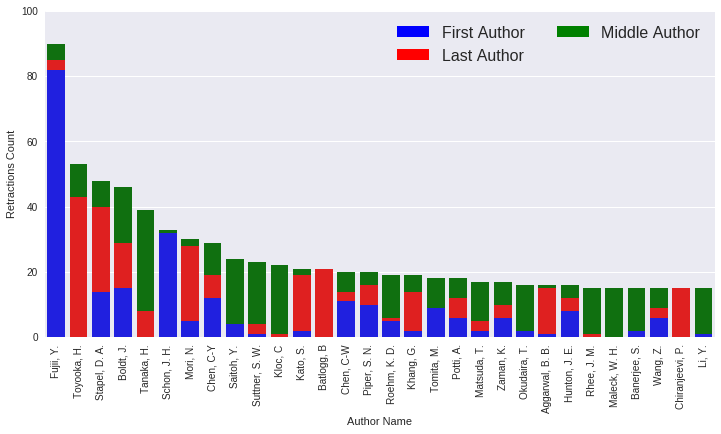

In [35]:
plt.figure(figsize=(12,6))
middle_author_bar = sns.barplot(x='author_name', y='count', data=auth_df.head(30), color='green');
last_author_bar = sns.barplot(x='author_name', y='first_and_last_author', data=auth_df.head(30), color='red');
first_author_bar = sns.barplot(x='author_name', y='first_author', data=auth_df.head(30), color='blue');
first_auth = plt.Rectangle((0,0),1,1,fc='blue', edgecolor = 'none')
last_auth = plt.Rectangle((0,0),1,1,fc='red', edgecolor = 'none')
middle_auth = plt.Rectangle((0,0),1,1,fc='green', edgecolor = 'none')
l = plt.legend([first_auth, last_auth, middle_auth], ['First Author', 'Last Author', 'Middle Author'], 
               loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)
plt.ylim([0,100])
plt.xlabel('Author Name')
plt.ylabel('Retractions Count')
plt.xticks(rotation=90);

### Saving DFs

In [36]:
retractions_df.to_pickle('./retractions_df.pkl')
summary_df.to_pickle('./summary_df.pkl')
unpacked_summary_df.to_pickle('./unpacked_summary_df.pkl')
author_summary_df.to_pickle('./author_summary_df.pkl')
adj_author_summary_df.to_pickle('./adj_author_summary_df.pkl')
auth_df.to_pickle('./auth_df.pkl')

### Loading DFs

In [10]:
retractions_df = pd.read_pickle('./retractions_df.pkl')
summary_df = pd.read_pickle('./summary_df.pkl')
unpacked_summary_df = pd.read_pickle('./unpacked_summary_df.pkl')
author_summary_df = pd.read_pickle('./author_summary_df.pkl')
adj_author_summary_df = pd.read_pickle('./adj_author_summary_df.pkl')
auth_df = pd.read_pickle('./auth_df.pkl')

retractions_df.iloc[1]['affiliation']

'Kazemimoghadam, Mansoor' in retractions_df.iloc[rid]['affiliation'].split('\n')[1]

retractions_df.iloc[rid]['affiliation'].split('\n')

rid = 420
affe = AffiliationExtractor()
aff_dc = affe.build_aff_dc(retractions_df.iloc[rid]['affiliation'], retractions_df.iloc[rid]['author'])
print aff_dc

rid = 4
for key in retractions_df.iloc[rid].keys():
    print key, retractions_df.iloc[rid][key]
    print '-------------------'

### Author affiliation country and continent

In [49]:
def get_most_common(ls):
    cnt = None
    if len(ls)==0 or ls is None:
        return 'Unkn'
    else:
        counter = Counter(ls)
        cnt = counter.most_common()
    #end
    return cnt[0][0]
#end

def build_primary_aff_cnt_dc(author_ls, df):
    primary_auth_aff_cnt_dc = dict()
    for author in author_ls:
        aff_cnt_ls = list(df['aff_country'][df['author_name']==author])
        flt_aff_cnt_ls = [el for el in aff_cnt_ls if el!='None']
        primary_auth_aff_cnt_dc[author] = get_most_common(flt_aff_cnt_ls)
    #end
    return primary_auth_aff_cnt_dc
#end

def build_aff_continent_dc(aff_cnt_dc, cnt2cont_map_dc):
    auth_aff_cont_dc = dict()
    for auth, cnt in zip(aff_cnt_dc.keys(), aff_cnt_dc.values()):
        auth_aff_cont_dc[auth] = cnt2cont_map_dc[cnt]
    #end
    return auth_aff_cont_dc
#end 
    

In [51]:
auth_ls = list(set(list(adj_author_summary_df['author_name'])))
aff_country_dc = build_primary_aff_cnt_dc(auth_ls, adj_author_summary_df)

In [52]:
with open('./aff_country_dc.pkl', 'wb') as handle:
    pickle.dump(aff_country_dc, handle, protocol=pickle.HIGHEST_PROTOCOL)
#end

In [54]:
country2cont_df = pd.read_pickle('./country2cont.pkl')

In [55]:
country2cont_df.head(3)

,continent_code,cc_a2,cc_a3,cc_#,country_name,country_st
0,AS,AF,AFG,4,"Afghanistan, Islamic Republic of",afghanistan islamic republic of
1,EU,AL,ALB,8,"Albania, Republic of",albania republic of
2,AN,AQ,ATA,10,Antarctica (the territory South of 60 deg S),antarctica (the territory south of 60 deg s)


### Load files

In [53]:
with open('./aff_country_dc.pkl', 'rb') as handle:
    aff_country_dc = pickle.load(handle)
#end

In [56]:
country2cont_df['country_st'] = country2cont_df['country_st'].apply(lambda x: x.decode('utf-8'))

### Building the author2continent dictionary

In [57]:
def check_perfect_match(df, cnt_name):
    if len(df[df['country_st']==cnt_name])>0:
        match100 = True
        cont = df['continent_code'][df['country_st']==cnt_name].item()
    else:
        match100 = False
        cont = 'Not found'
    #end
    return match100, cont
#end

def check_perfect_match3(df, cnt_name):
    if len(df[df['cc_a3']==cnt_name])>0:
        match3 = True
        cont = df['continent_code'][df['cc_a3']==cnt_name].item()
    else:
        match3 = False
        cont = 'Not found'
    #end
    return match3, cont
#end

def check_perfect_match2(df, cnt_name):
    if len(df[df['cc_a2']==cnt_name])>0:
        match2 = True
        cont = df['continent_code'][df['cc_a2']==cnt_name].item()
    else:
        match2 = False
        cont = 'Not found'
    #end
    return match2, cont
#end

def check_in_list(df, cnt_name):
    cnt_name_ls = list(df['country_st'])
    match_ls = False
    cont = 'Not found'
    for iloc, cname in enumerate(cnt_name_ls):
        if cnt_name in cname:
            return True, df['continent_code'].iloc[iloc]
        #end
    #end
    return match_ls, cont
#end

def build_cnt2cont_map_dc(aff_cnt_dc, country2cont_df):
    aff_cont_map_dc = dict()
    for auth, country in zip(aff_cnt_dc.keys(), aff_cnt_dc.values()):
        if country=='Unkn':
            aff_cont_map_dc['Unkn'] = 'Unkn'
        else:
            country_st = country.lower().replace('.', '').replace(',', '')
            found, cont = check_perfect_match(country2cont_df, country_st)
            if found:
                aff_cont_map_dc[country] = cont
            elif len(country_st)==3:
                found, cont = check_perfect_match3(country2cont_df, country_st)
                aff_cont_map_dc[country] = cont
            elif len(country_st)==2:
                found, cont = check_perfect_match2(country2cont_df, country_st)
                aff_cont_map_dc[country] = cont
            else:
                found, cont = check_in_list(country2cont_df, country_st)
                aff_cont_map_dc[country] = cont
            #end
        #end
    #end
    return aff_cont_map_dc
#end                    

### Fixing manually

In [58]:
subst_dc = {'2ER,LANARK,SCOTLAND': 'United Kingdom',
            '2T5,QUEBEC,CANADA': 'Canada',
            '980,JAPAN': 'Japan',
            'England': 'United Kingdom',
            'FERRAND,FRANCE': 'France',
            'LEIPZIG,GERMANY': 'Germany',
            'Scotland': 'United Kingdom',
            'St': 'Unkn',
            'USA': 'United States of America',
            'Wales': 'United Kingdom',
            'Zaire': 'Congo'}
for author, country in aff_country_dc.iteritems():
    for old, new in zip(subst_dc.keys(), subst_dc.values()):
        if country == old:
            aff_country_dc[author] = new
        #end
    #end
#end

In [59]:
aff_cnt2cont_dc = build_cnt2cont_map_dc(aff_country_dc, country2cont_df)

In [60]:
auth_cont_dc = build_aff_continent_dc(aff_country_dc, aff_cnt2cont_dc)

### Saving and loading the author to continent dictionary

In [61]:
with open('./auth_cont_dc.pkl', 'wb') as handle:
    pickle.dump(auth_cont_dc, handle, protocol=pickle.HIGHEST_PROTOCOL)
#end

In [62]:
with open('./auth_cont_dc.pkl', 'rb') as handle:
    auth_cont_dc = pickle.load(handle)
#end

### Loading manually produced authors continent .csv

In [121]:
df = pd.read_csv('./filt_author_cont.csv', names=['author', 'continent'], keep_default_na=False, na_values=['_'])
manual_cont_dc = dict(zip(list(df['author']), list(df['continent'])))

In [122]:
for key, value in zip(same_author_dc.keys(), same_author_dc.values()):
    if key in manual_cont_dc.keys():
        manual_cont_dc[value] = manual_cont_dc.pop(key)
    #end
#end

In [123]:
for auth, cont in manual_cont_dc.items():
    auth_cont_dc[auth] = cont
#end

### Network analysis

#### Some boilerplate

In [65]:
def build_edge_weight_dc(article_ID_ls, adj_author_summary_df, author_label_dc, double=False):
    edge_weight_dc = dict() 
    for art_id in article_ID_ls:
        art_auth_ls = list(adj_author_summary_df['author_name'][adj_author_summary_df['ID']==art_id])
        if 'None' in art_auth_ls:
            art_auth_ls.remove('None')
        #end
        if '{[}Anonymous], ' in art_auth_ls:
            art_auth_ls.remove('{[}Anonymous], ')
        #end
        if len(art_auth_ls)>1:
            for index, a1 in enumerate(art_auth_ls):
                if double:
                    for a2 in art_auth_ls:
                        if author_label_dc[a1]!=author_label_dc[a2]:
                            if (a1, a2) in edge_weight_dc:
                                edge_weight_dc[(a1, a2)] = edge_weight_dc[(a1, a2)] + 1
                            else:
                                edge_weight_dc[(a1, a2)] = 1
                            #end
                        #end
                    #end
                else:
                    for a2 in art_auth_ls[index+1:]:
                        if author_label_dc[a1]<author_label_dc[a2]:
                            if (a1, a2) in edge_weight_dc:
                                edge_weight_dc[(a1, a2)] = edge_weight_dc[(a1, a2)] + 1
                            else:
                                edge_weight_dc[(a1, a2)] = 1
                            #end
                        #end
                    #end
                #end
            #end
        #end
    #end
    return edge_weight_dc
#end

In [124]:
author_ls = list(set(adj_author_summary_df['author_name']))
author_ls.remove('None')
author_ls.remove('{[}Anonymous], ')
article_ID_ls = list(set(adj_author_summary_df['ID']))
author_label_dc = dict(zip(author_ls, range(len(author_ls))))
author_retraction_count_dc = dict(zip(list(auth_df['author_name']), list(auth_df['count'])))
author_retraction_first_dc = dict(zip(list(auth_df['author_name']), list(auth_df['first_author'])))
author_retraction_last_dc = dict(zip(list(auth_df['author_name']), list(auth_df['last_author'])))
author_retraction_middle_dc = dict(zip(list(auth_df['author_name']), list(auth_df['middle_author'])))

#### Building nodes and edges

#### Building the big network

In [67]:
color_map = {'NA': '#4169E1', 'SA': '#CD3333', 'AS': '#FFA500', 'EU': '#228B22',
             'AF': '#DB70DB', 'OC': '#B0E2FF', 'Unkn': '#888888'}

In [68]:
def build_node_attr_dc():
    att_dc = dict()
    for auth in author_ls:
        att_dc[auth] = {'count': author_retraction_count_dc[auth],
                        'first': author_retraction_first_dc[auth],
                        'last': author_retraction_last_dc[auth],
                        'middle': author_retraction_middle_dc[auth],
                        'aff_country': aff_country_dc[auth],
                        'aff_cont': auth_cont_dc[auth],
                        'node_color': color_map[auth_cont_dc[auth]]
                        }
    #end
    return att_dc
#end

In [125]:
auth_net_node_att_dc = build_node_attr_dc()

In [70]:
def build_network():
    G = nx.Graph()
    for auth in author_ls:
        G.add_node(auth, auth_net_node_att_dc[auth])
    #end
    for co_authors in edge_weight_dbl_dc:
        G.add_edge(*co_authors, weight=edge_weight_dbl_dc[co_authors])
    #end
    return G
#end

In [71]:
def filter_network(G, n_auth=8):
    Top_n_auth_G = G.copy()

    n = 8
    top_n_auth_ls = list(set((auth_df['author_name'].head(n))))
    top_n_auth_connection_ls = top_n_auth_ls

    for auth in top_n_auth_ls:
        top_n_auth_connection_ls = top_n_auth_connection_ls + G.edge[auth].keys()
    #end

    top_n_auth_connection_ls = list(set(top_n_auth_connection_ls))
    discard_ls = [auth for auth in author_ls if auth not in top_n_auth_connection_ls]
    Top_n_auth_G.remove_nodes_from(discard_ls)
    return Top_n_auth_G
#end

In [126]:
edge_weight_dbl_dc = build_edge_weight_dc(article_ID_ls, adj_author_summary_df, author_label_dc, double=True)
G = build_network()

In [127]:
Top_n_auth_G = filter_network(G, n_auth=8)

### Plots

In [92]:
figsize = (18,12)

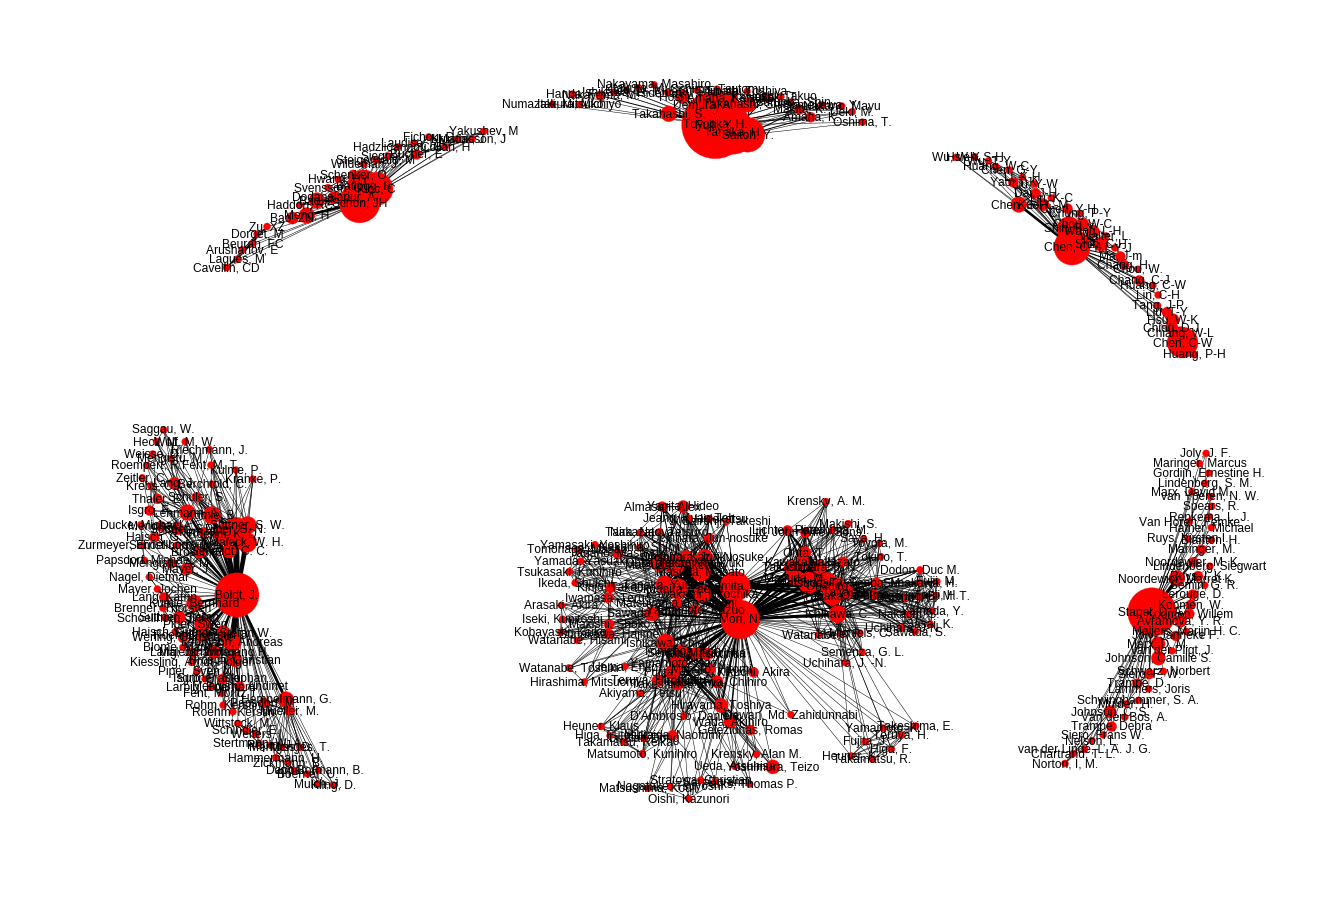

In [39]:
plt.figure(figsize=figsize)
node_size_ls = [50*Top_n_auth_G.node[a]['count'] for a in Top_n_auth_G.nodes()]
edge_weight_ls = [0.5*Top_n_auth_G.edge[a][b]['weight'] for a, b in Top_n_auth_G.edges()]
pos = nx.spring_layout(Top_n_auth_G)
nx.draw(Top_n_auth_G, pos, node_size=node_size_ls, width=edge_weight_ls)
nx.draw_networkx_labels(Top_n_auth_G, pos, node_size=node_size_ls, width=edge_weight_ls);
#plt.savefig('./net_cluster.jpg')

print pos['Toyooka, H.'], pos['Fujii, Y.'], pos['Tanaka, H.'], pos['Mori, N.']

In [79]:
def assign_initial_pos(G):
    pos_ini_dc = dict()
    for node in G.nodes():
        pos_ini_dc[node] = 100*np.random.random(2)
    #end
    pos_ini_dc['Fujii, Y.'] = np.array([85.0, 85.0])
    pos_ini_dc['Toyooka, H.'] = np.array([72.0, 78.0])
    pos_ini_dc['Tanaka, H.'] = np.array([80.0, 70.0])
    pos_ini_dc['Stapel, D. A.'] = np.array([35.0, 80.0])
    pos_ini_dc['Boldt, J.'] = np.array([65.0, 15.0])
    pos_ini_dc['Schon, J. H.'] = np.array([20.0, 15.0])
    pos_ini_dc['Mori, N.'] = np.array([50.0, 40.0])
    pos_ini_dc['Chen, C-Y'] = np.array([10.0, 50.0])
    return pos_ini_dc
#end   

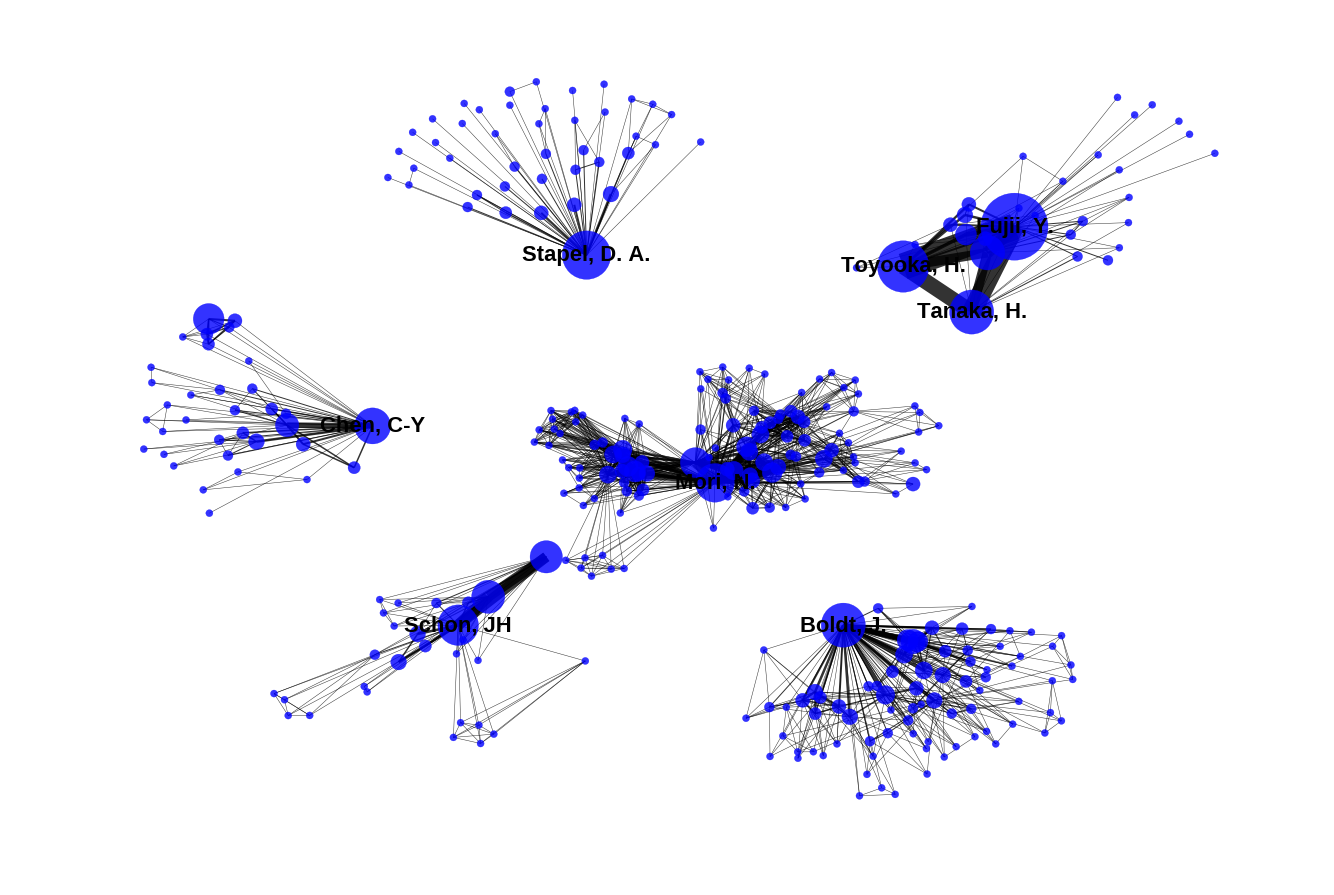

In [108]:
plt.figure(figsize=figsize)
top_n_auth_ls = list(set((auth_df['author_name'].head(8))))
pos_ini_dc = assign_initial_pos(Top_n_auth_G)
node_size_ls = [50*Top_n_auth_G.node[a]['count'] for a in Top_n_auth_G.nodes()]
edge_weight_ls = [0.5*Top_n_auth_G.edge[a][b]['weight'] for a, b in Top_n_auth_G.edges()]
#dim=2, k=None, pos=None, fixed=None, iterations=50, weight='weight', scale=1.0
pos = nx.spring_layout(Top_n_auth_G, k=None, iterations=18, pos=pos_ini_dc, 
                       fixed=top_n_auth_ls, scale=1.0)
nx.draw(Top_n_auth_G, pos, node_size=node_size_ls, width=edge_weight_ls, node_color='blue', alpha=0.8, edge_color='black')

labels = {}
for node in top_n_auth_ls:
    labels[node] = node
#end
nx.draw_networkx_labels(Top_n_auth_G, pos, labels, font_size=22, font_weight='bold', font_color='black');
#plt.savefig('./net_cluster.jpg')

### Assigning node color to nodes

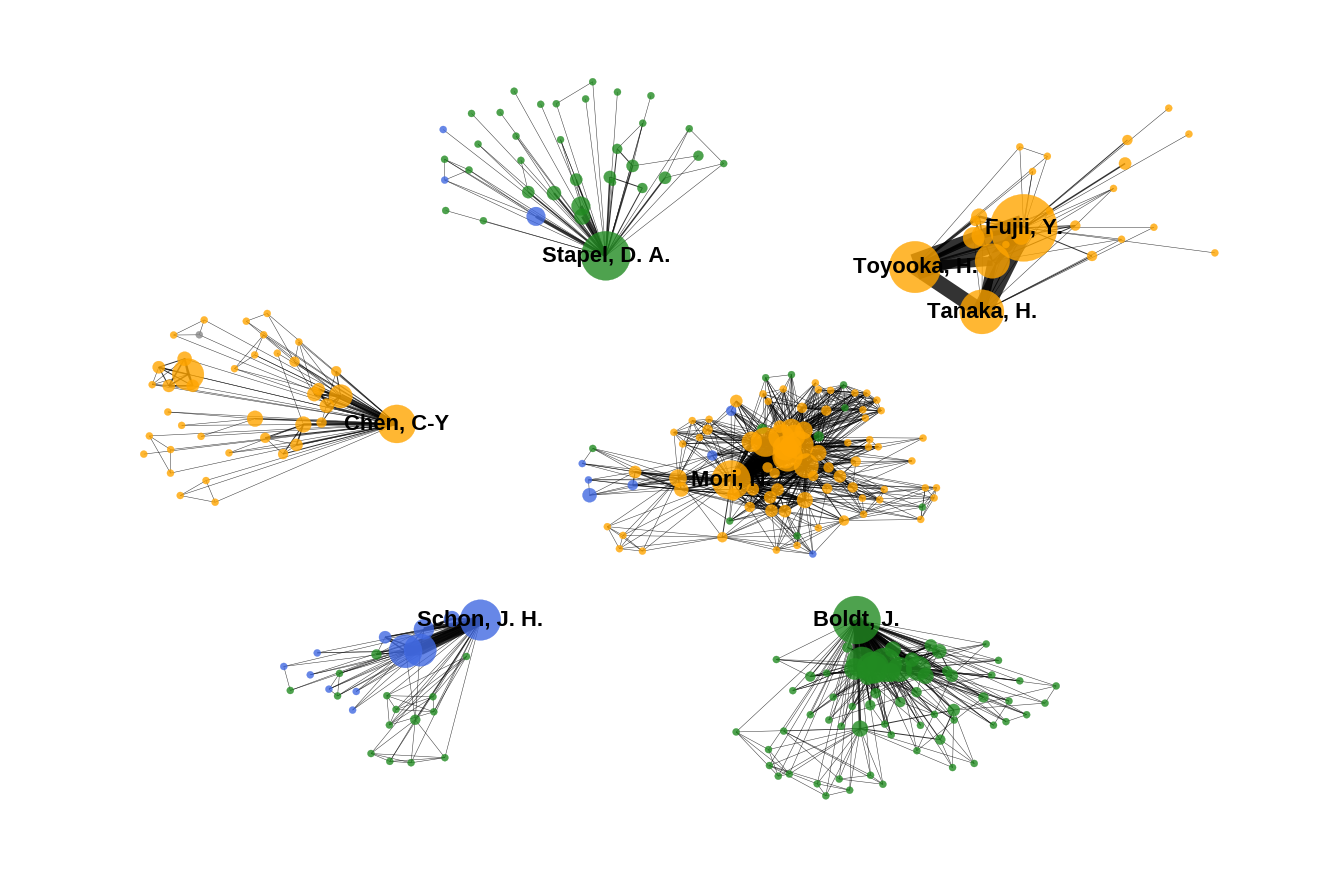

In [128]:
plt.figure(figsize=figsize)
top_n_auth_ls = list(set((auth_df['author_name'].head(8))))
pos_ini_dc = assign_initial_pos(Top_n_auth_G)
node_size_ls = [50*Top_n_auth_G.node[a]['count'] for a in Top_n_auth_G.nodes()]
edge_weight_ls = [0.5*Top_n_auth_G.edge[a][b]['weight'] for a, b in Top_n_auth_G.edges()]
node_color_ls = [auth_dc['node_color'] for auth, auth_dc in zip(Top_n_auth_G.node.keys(), Top_n_auth_G.node.values())]
#dim=2, k=None, pos=None, fixed=None, iterations=50, weight='weight', scale=1.0
pos = nx.spring_layout(Top_n_auth_G, k=None, iterations=18, pos=pos_ini_dc, 
                       fixed=top_n_auth_ls, scale=1.0)
nx.draw(Top_n_auth_G, pos, node_size=node_size_ls, width=edge_weight_ls, 
        node_color=node_color_ls, alpha=0.8, edge_color='black')

labels = {}
for node in top_n_auth_ls:
    labels[node] = node
#end
nx.draw_networkx_labels(Top_n_auth_G, pos, labels, font_size=22, font_weight='bold', font_color='black');
plt.savefig('./clusters_colored_01.jpg')

In [129]:
nx.write_gpickle(G, "./full_network.gpkl")
nx.write_gpickle(Top_n_auth_G, "./top8auth_ntwk.gpkl")

#### Filtering out edges among minor authors

Let us see if we can polish things a bit by eliminating the edges between authors that are not in the top 8.

In [43]:
Top_n_auth_filtered_G = G.copy()

n = 8
top_n_auth_ls = list(set((auth_df['author_name'].head(n))))
top_n_auth_connection_ls = top_n_auth_ls

for auth in top_n_auth_ls:
    top_n_auth_connection_ls = top_n_auth_connection_ls + G.edge[auth].keys()
#end

top_n_auth_connection_ls = list(set(top_n_auth_connection_ls))
discard_ls = [auth for auth in author_ls if auth not in top_n_auth_connection_ls]
Top_n_auth_filtered_G.remove_nodes_from(discard_ls)

remove_edge_ls = list()
for auth in top_n_auth_connection_ls:
    for conn in Top_n_auth_filtered_G.edge[auth].keys():
        if ((auth not in top_n_auth_ls) and (conn not in top_n_auth_ls)):
            remove_edge_ls = remove_edge_ls + [(auth, conn), (conn, auth)]
        #end
    #end
#end

Top_n_auth_filtered_G.remove_edges_from(remove_edge_ls)

node_size_ls = [50*Top_n_auth_filtered_G.node[a]['count'] for a in Top_n_auth_filtered_G.nodes()]
edge_weight_ls = [0.5*Top_n_auth_filtered_G.edge[a][b]['weight'] for a, b in Top_n_auth_filtered_G.edges()]

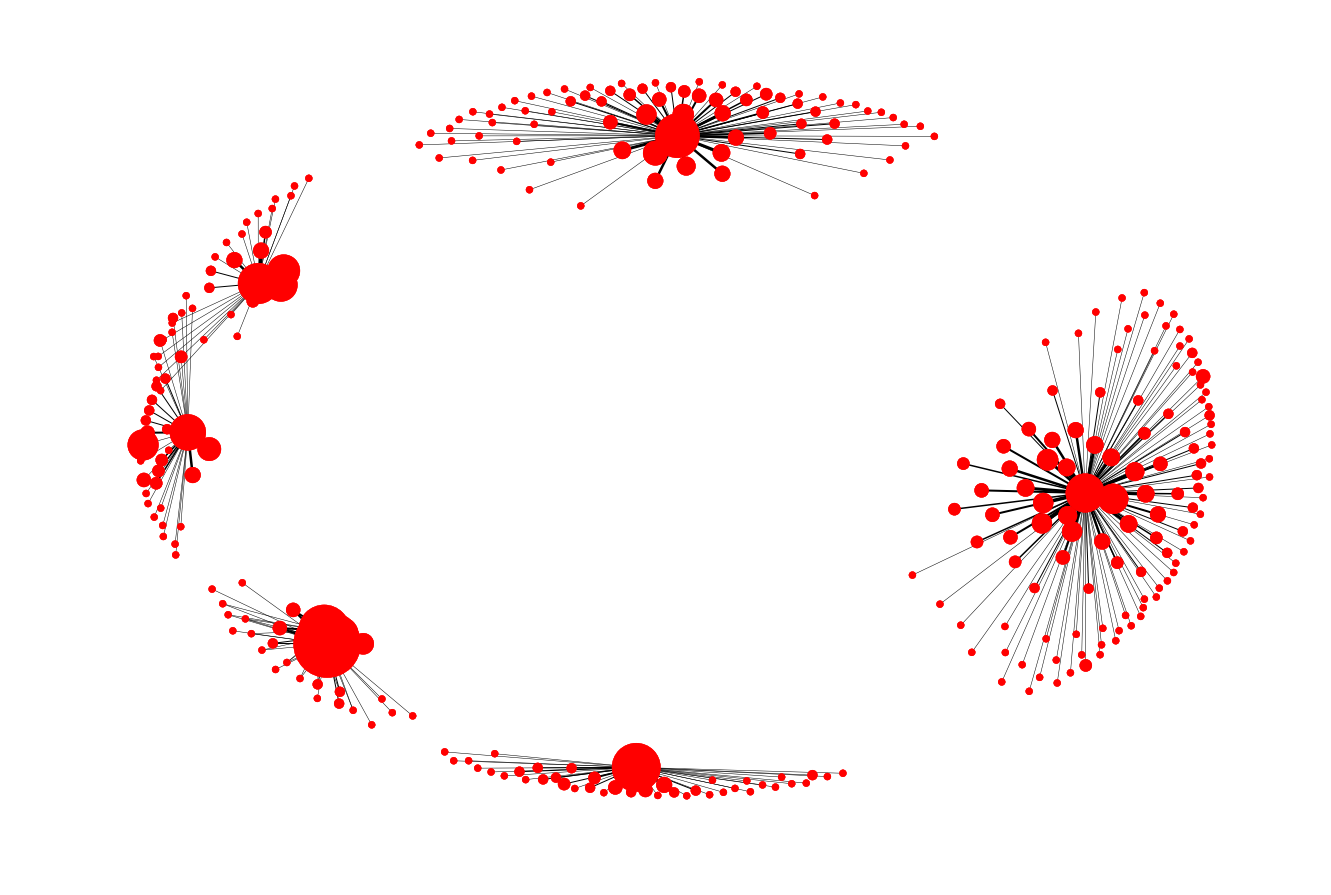

In [48]:
plt.figure(figsize=(18,12))
pos = nx.spring_layout(Top_n_auth_filtered_G)
nx.draw(Top_n_auth_filtered_G, pos, node_size=node_size_ls, width=edge_weight_ls)
nx.draw_networkx_nodes(Top_n_auth_filtered_G, pos, node_size=node_size_ls, width=edge_weight_ls, linewidth=1.0);
#nx.draw_networkx_labels(Top_n_auth_filtered_G, pos, labels=None, node_size=node_size_ls, width=edge_weight_ls);

Unfortunately, the plotting algorithm changes the position of the clusters once the network changes and we need to pay attention to which cluster we are referring to, but the overall considerations made before are reinforced by the analysis of this last plot.

#### Middle authors graph

As additional analyis, I am going to explore the clustering of middle authors only. That is, I would like to see how the top 8 authors, but middle author retraction count, are connected to the resto of the author population.

In [67]:
mddl_author_ls = list(set(adj_author_summary_df['author_name'][adj_author_summary_df['middle_author']==1]))
mddl_article_ID_ls = list(set(adj_author_summary_df['ID'][adj_author_summary_df['middle_author']==1]))
mddl_author_label_dc = dict(zip(mddl_author_ls, range(len(mddl_author_ls))))
author_retraction_count_dc = dict(zip(list(auth_df['author_name']), list(auth_df['count'])))
author_retraction_first_dc = dict(zip(list(auth_df['author_name']), list(auth_df['first_author'])))
author_retraction_last_dc = dict(zip(list(auth_df['author_name']), list(auth_df['last_author'])))
author_retraction_middle_dc = dict(zip(list(auth_df['author_name']), list(auth_df['middle_author'])))

In [68]:
mddl_adj_author_summary_df = adj_author_summary_df[adj_author_summary_df['middle_author']==1]
mddl_edge_weight_dbl_dc = build_edge_weight_dc(mddl_article_ID_ls, mddl_adj_author_summary_df, 
                                               mddl_author_label_dc, double=True)

In [69]:
G = nx.Graph()

for auth in mddl_author_ls:
    G.add_node(auth, count=author_retraction_count_dc[auth])
    G.add_node(auth, first=author_retraction_first_dc[auth])
    G.add_node(auth, last=author_retraction_last_dc[auth])
    G.add_node(auth, middle=author_retraction_middle_dc[auth])
#end
for co_authors in mddl_edge_weight_dbl_dc:
    G.add_edge(*co_authors, weight=mddl_edge_weight_dbl_dc[co_authors])
#end

In [70]:
Top_n_mddl_auth_G = G.copy()

n = 8

temp_df = auth_df.sort_values(by='middle_author', ascending=False).reset_index(drop=True)

top_n_auth_ls = list(set((temp_df['author_name'].head(n))))
top_n_auth_connection_ls = top_n_auth_ls

for auth in top_n_auth_ls:
    top_n_auth_connection_ls = top_n_auth_connection_ls + G.edge[auth].keys()
#end

top_n_auth_connection_ls = list(set(top_n_auth_connection_ls))
discard_ls = [auth for auth in author_ls if auth not in top_n_auth_connection_ls]
Top_n_mddl_auth_G.remove_nodes_from(discard_ls)

node_size_ls = [50*Top_n_mddl_auth_G.node[a]['count'] for a in Top_n_mddl_auth_G.nodes()]
edge_weight_ls = [0.5*Top_n_mddl_auth_G.edge[a][b]['weight'] for a, b in Top_n_mddl_auth_G.edges()]

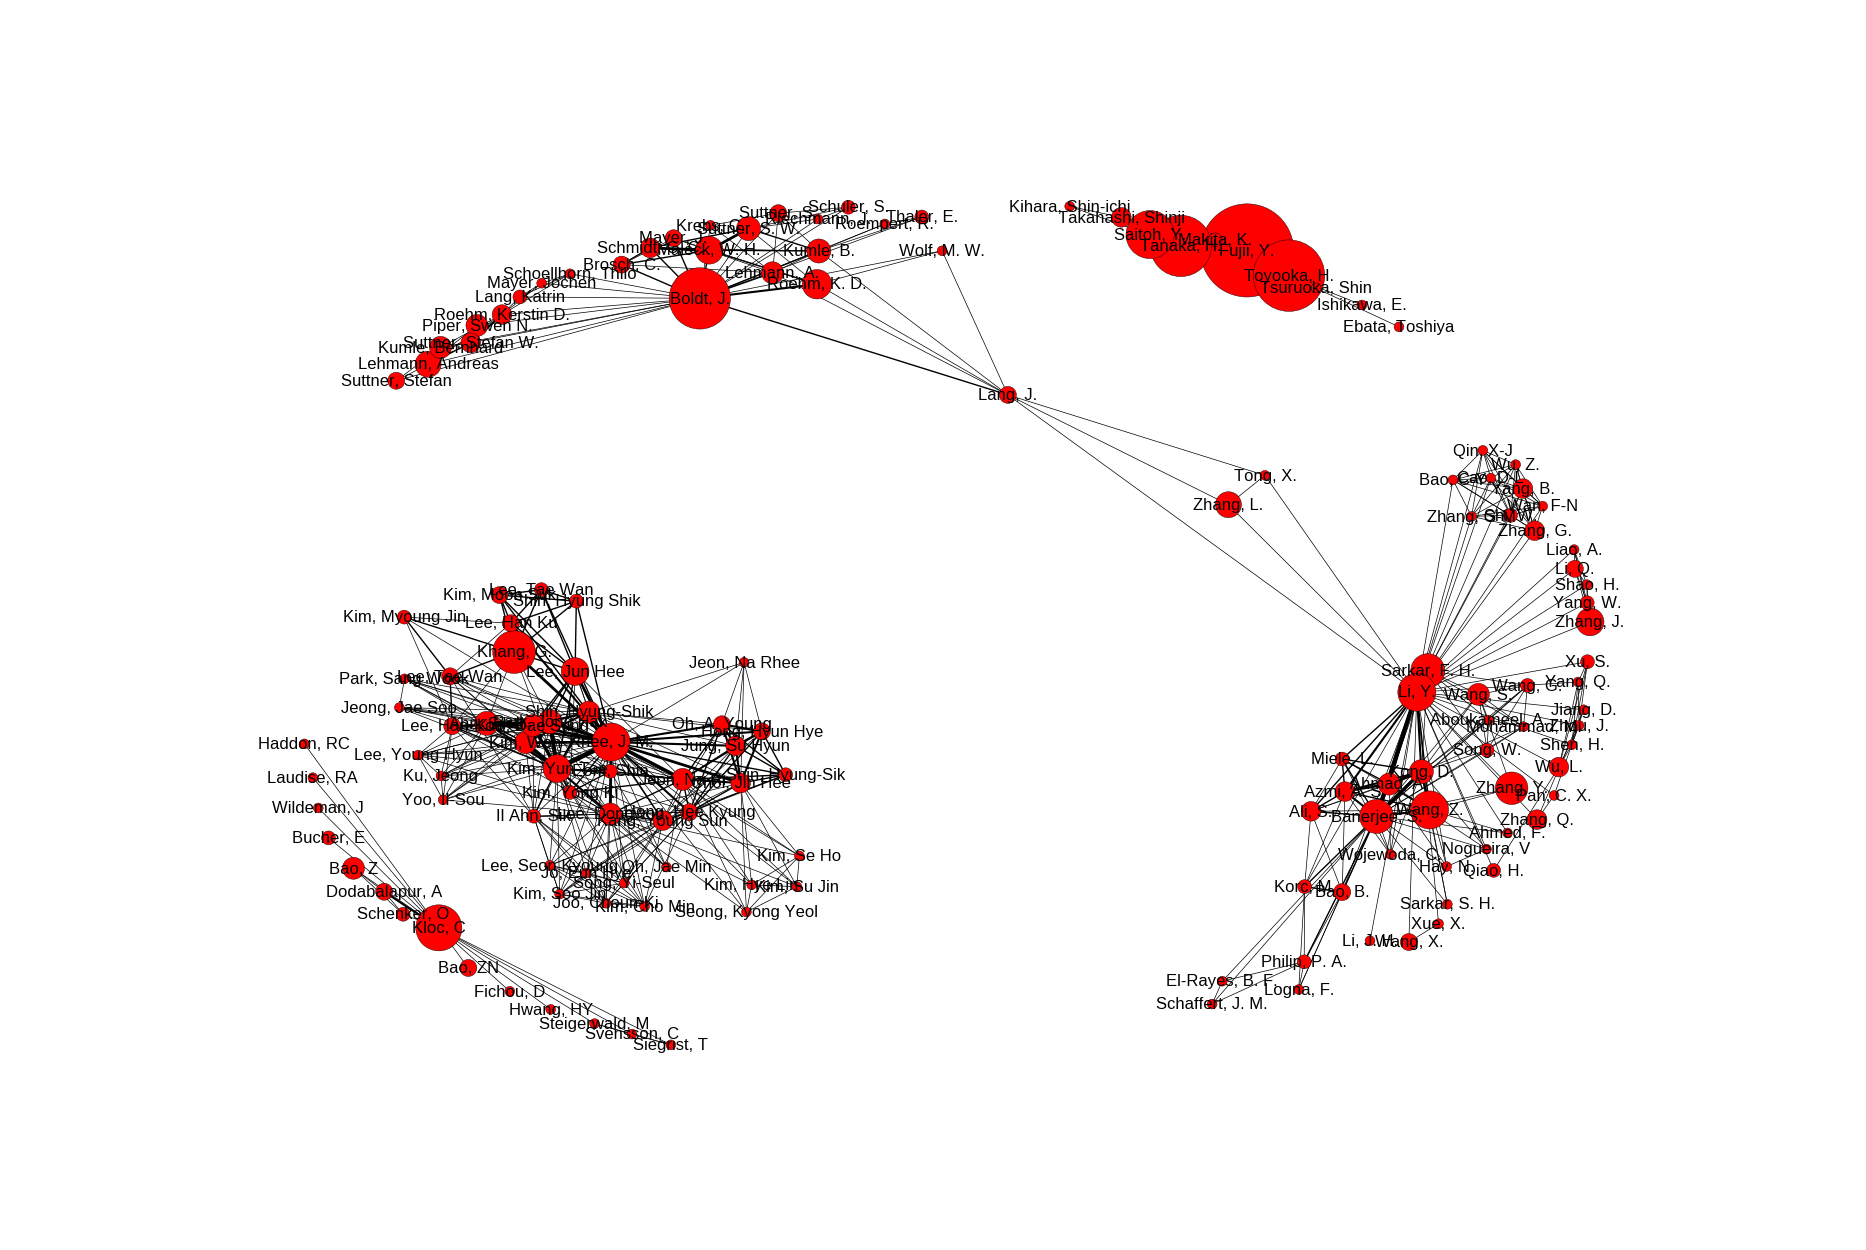

In [73]:
plt.figure(figsize=(18,12))
pos = nx.spring_layout(Top_n_mddl_auth_G)
nx.draw(Top_n_mddl_auth_G, pos, node_size=node_size_ls, width=edge_weight_ls)
nx.draw_networkx_labels(Top_n_mddl_auth_G, pos, node_size=node_size_ls, width=edge_weight_ls);